# Deep learning tests

## Load libraries and data

In [1]:
import scipy.io as scio
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import tqdm

In [38]:
data3_1 = scio.loadmat('tissue3_1.mat')
data3_2 = scio.loadmat('tissue3_2.mat')
data4 = scio.loadmat('tissue4.mat') 
data5 = scio.loadmat('tissue5.mat')
data6 = scio.loadmat('tissue6.mat')
data14 = scio.loadmat('tissue14.mat')
data24 = scio.loadmat('tissue24.mat')

In [78]:
int_tissue_5 = data3_1['tissue_t3_1'].copy()
for i in range(200):
    for j in range(200):
        int_tissue_5[i,j] = int(data5['tissue_t5_1'][i,j]) 

tissue_train = [
    (data3_1['map_t3'], data3_1['tissue_t3_1']),
    (data4['map_t4'],   data4['tissue_t4']    ), 
    (data5['map_t5_1'], int_tissue_5  ),
    (data6['map_t6'],   data6['tissue_t6']    ),
    (data14['map_t14'], data14['tissue_t14']  ),
    (data3_2['map_t3'], data3_2['tissue_t3_2']),
    (data24['map_t24'], data24['tissue_t24']  )
]

In [83]:
tissue_train = [
    (data3_1['map_t3'], data3_1['bcc']),
    (data6['map_t6'],   data6['bcc']),
    (data4['map_t4'],   data4['bcc'])
]

tissue_test = [
    (data14['map_t14'], data14['tissue_t14']  ),
    (data24['map_t24'], data24['tissue_t24']  )
]

### Processed data + PCA dim red

In [3]:
import blosc
import pickle
def decompress(file,prealloc_arr=None):
    f=open(file,"rb")
    shape,arr_size,dtype,is_f_contiguous,num_chunks,max_num=pickle.load(f)

    if prealloc_arr is None:
        arr=np.empty(arr_size,dtype)
    else:
        arr=np.frombuffer(prealloc_arr.data, dtype=dtype, count=arr_size)

    for i in range(num_chunks):
        size=np.fromfile(f,np.uint32,count=1)
        c=f.read(size[0])
        blosc.decompress_ptr(c, arr[max_num*i:].__array_interface__['data'][0])
    f.close()

    #reshape
    if is_f_contiguous:
        arr=arr.reshape(shape[::-1]).T
    else:
        arr=arr.reshape(shape)
    return arr

In [4]:
import mat73
data3_1 = scio.loadmat('../Data/tissue3_1.mat')
data8_1 = scio.loadmat('../Data/tissue8_1.mat')
data13 = mat73.loadmat('../Data/tissue_t13_workspace.mat')
data17 = mat73.loadmat('../Data/tissue_t17_workspace.mat')
data39_1 = scio.loadmat('../Data/tissue39_1.mat')

no_baseline_3_1   = decompress('../Preprocessed/t3_1.lz4')
no_baseline_8_1   = decompress('../Preprocessed/t8_1.lz4')
no_baseline_13    = decompress('../Preprocessed/t13.lz4')
no_baseline_17    = decompress('../Preprocessed/t17.lz4')
no_baseline_39_1  = decompress('../Preprocessed/t39_1.lz4')

In [5]:
from random import randint
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
def my_pca_rand(tissue, pca_components):
    pca_training_data = np.zeros((1000,1024))
    
    count = 0
    for (t_map,t_bcc) in tissue:
        count1 = 0    
        for _ in range(50):  
            i = randint(0,199)
            j = randint(0,199)
            if count < 1000 and count1 < 50:
                pca_training_data[count,:] = t_map[i,j,:]
                count  += 1
                count1 += 1
                        
    ### Perform PCA dimensionality reduction ###
    norm_data = normalize(pca_training_data)
    pca = PCA(n_components=pca_components) 
    pca.fit(norm_data)

    final_tissue = []
    for (t_map,t_bcc) in tissue:
        transformed = np.zeros((200,200,pca_components))
        for i in range(200):
            transformed[i,:,:] = pca.transform(t_map[i,:,:])
            
        final_tissue.append((transformed, t_bcc))
        
    return final_tissue


In [6]:
tissue = [
    (no_baseline_3_1, data3_1['bcc']),
    (no_baseline_8_1, data8_1['bcc']),
    (no_baseline_13,  data13['bcc']),
    (no_baseline_17,  data17['bcc']),
    (no_baseline_39_1, data39_1['bcc']),
]

tissue = my_pca_rand(tissue, 50)

tissue_train = tissue[:3]
tissue_test  = tissue[3:]

## Define Network

Code taken from https://github.com/milesial/Pytorch-UNet/blob/e1a69e7c6ce18edd47271b01e4aabc03b436753d/unet

### UNet structure

A contracting path (4 steps):
1. 2 convolutions: 3x3, no padding
2. ReLU
3. Max pooling: 2x2, stride=2

An expansive path (4 steps):
1. Upsampling feature map
2. Convolution: 2x2
3. Conatenate feature map
4. 2 convolutions: 3x3, no padding
5. ReLU
    
A final step:
1. Convolution: 1x1 

In [7]:
class DoubleConv(nn.Module):
    """
    2 rounds of...
    - 2D convolution: 3x3, padding=1 (should be no padding!)
    - Batch normalisation
    - ReLU
    """

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), # CHANGE TO NO PADDING
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1), # CHANGE TO NO PADDING
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [8]:
class Down(nn.Module):
    """
    One step of the contracting path:
    - Max pooling (downscaling)
    - Double convolution
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),                            # ADD STRIDE=2
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [9]:
class Up(nn.Module):
    """
    One step of the expansive path:
    - Upsampling with convolution
    - Double convolution
    """

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [10]:
class OutConv(nn.Module):
    """
    Final step:
    - Single convolution
    """

    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
class UNet(nn.Module):
    ''' 
    Input should be of size (N,Cin,H,W) = (1,1024,200,200)
    Output should be of size (N,Cout,H,W) = (1,16,200,200)
    '''

    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Model Training

In [12]:
def train_model(model, data, target, PCA_COMP=1024, num_epochs = 100):
                        
        # Make sure input image is square
        if min(target.shape) == 200:
                size = 200 
        if min(target.shape) == 100:
                size = 100 
        
        # Reshape matrix into array
        X = []
        for i in range(size):
                for j in range(size):
                        X.append(data[i,j,:])

        y = target[0:size,0:size].reshape(1,size,size)
        
        # Reshape data for test & train
        scaler = sklearn.preprocessing.StandardScaler()

        X = scaler.fit_transform(X)
        X = X.reshape(1,PCA_COMP,size,size)

        tensor_X = torch.Tensor(X)
        tensor_y = torch.Tensor(y).long()

        # Train model
        model.train();

        for _ in tqdm.trange(num_epochs):
                optimizer.zero_grad()
                y_pred = model(tensor_X)
                loss = criterion(y_pred, tensor_y)
                loss.backward()
                optimizer.step()

In [18]:
def test_model(model, data, target, PCA_COMP=1024):
                        
        # Make sure input image is square
        if min(target.shape) == 200:
                size = 200 
        if min(target.shape) == 100:
                size = 100 

        # Reshape matrix into array
        X = []
        for i in range(size):
                for j in range(size):
                        X.append(data[i,j,:])
        
        # Reshape data for test & train
        scaler = sklearn.preprocessing.StandardScaler()

        X = scaler.fit_transform(X)
        X = X.reshape(1,PCA_COMP,size,size)
        
        tensor_X = torch.Tensor(X)
        
        # Evaluate model
        model.eval();
        y_pred = model(tensor_X)
        
        # Create image from results
        results = []

        for i in range(size):
                for j in range(size):
                        array = y_pred[0,:,i,j].detach().numpy()
                        index = np.argmax(array)
                        results.append(index)
        
        approximation = np.zeros((size,size))
        for i in range(size):
                for j in range(size):
                        index = i*size + j
                        approximation[i,j] = results[index]
        
        # Plot images
        _, axs = plt.subplots(1,2, figsize=(10,5))
        axs[0].imshow(target)
        axs[0].title.set_text('Target')
        axs[1].imshow(approximation)
        axs[1].title.set_text('UNet estimate')
        plt.show()

## Run UNet

100%|██████████| 100/100 [08:23<00:00,  5.03s/it]


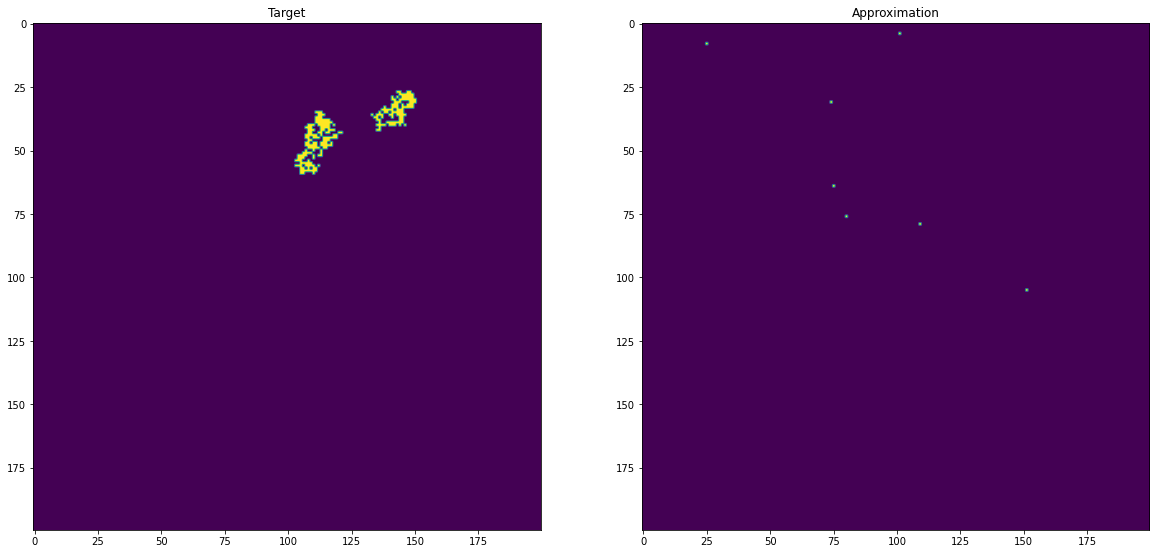

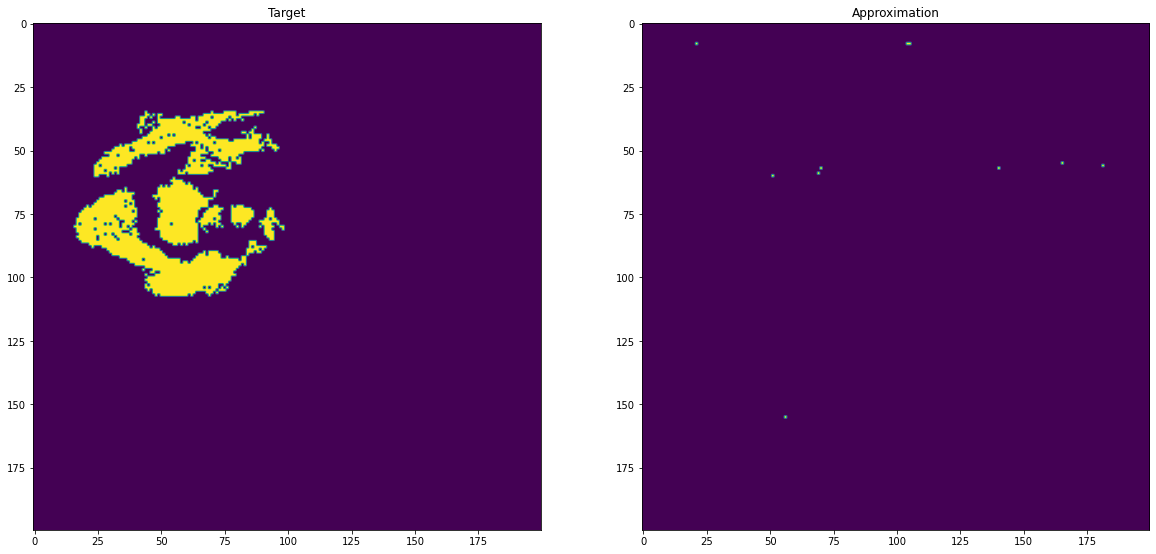

In [16]:
model = UNet(50,2)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for (data, target) in tissue_train:
    train_model(model, data,target,50)

for (data, target) in tissue_test:
    test_model(model, data,target,50)


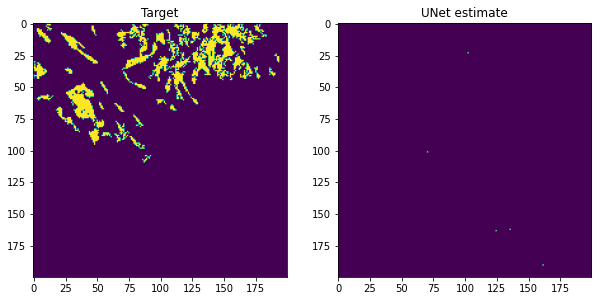

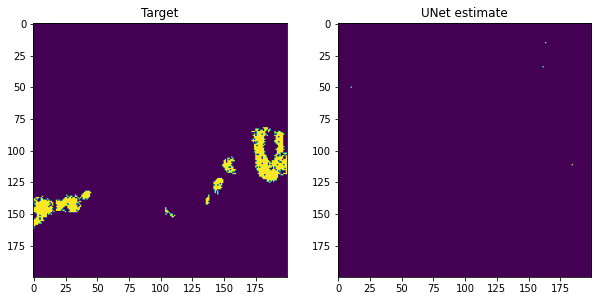

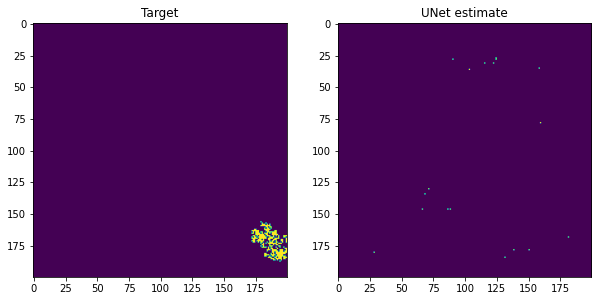

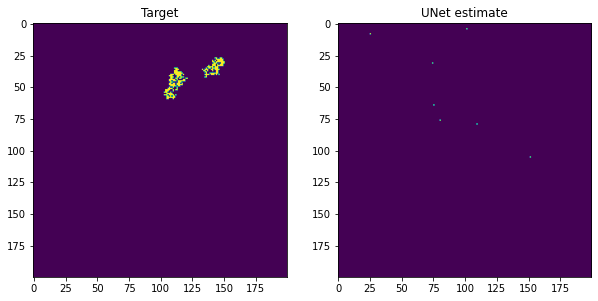

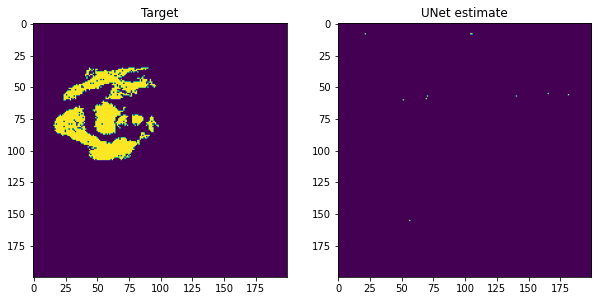

In [20]:
for (data, target) in tissue_train:
    test_model(model, data,target,50)

for (data, target) in tissue_test:
    test_model(model, data,target,50)